In [ ]:
import IPython
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/g-nazos/audio-deepfake-detection -q
%cd project

!python run.py
!cp outputs/* /content/drive/MyDrive/colab_jobs/project/results/


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
import gradio as gr
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torch
import librosa
import os

# Load model and processor
model_name = "prithivMLmods/Common-Voice-Geneder-Detection"
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

# Label mapping
id2label = {
    "0": "female",
    "1": "male"
}

def classify_audio(audio_path):
    # Load and resample audio to 16kHz
    speech, sample_rate = librosa.load(audio_path, sr=16000)

    # Process audio
    inputs = processor(
        speech,
        sampling_rate=sample_rate,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).squeeze().tolist()

    prediction = {
        id2label[str(i)]: round(probs[i], 3) for i in range(len(probs))
    }

    return prediction
# Loop through all files in the folder
folder_path="/kaggle/input/the-fake-or-real-dataset/for-2sec/for-2seconds/training/real"
for filename in os.listdir(folder_path):
    if filename.endswith((".wav",".mp3")):  # or ".mp3", etc.
        file_path = os.path.join(folder_path, filename)
        # Gradio Interface
        iface = gr.Interface(
            fn=classify_audio,
            inputs=gr.Audio(type=file_path, label="Upload Audio (WAV, MP3, etc.)"),
            outputs=gr.Label(num_top_classes=2, label="Gender Classification"),
            title="Common Voice Gender Detection",
            description="Upload an audio clip to classify the speaker's gender as female or male."
        )

if __name__ == "__main__":
    iface.launch()


In [31]:
df_gender_test=df.copy()

df_prediction = df_gender_test[['female','male']].idxmax(axis=1)
df_result_test = pd.concat([df_gender_test,df_prediction], axis=1)
print(df_result_test)
df_result_test=df_result_test.drop(df_result_test.columns[[1,2]],axis=1)
df_result_test.rename(columns={0: 'predictions'}, inplace=True)
df_result_test

                                              filename  female   male       0
0    file2030.wav_16k.wav_norm.wav_mono.wav_silence...   0.003  0.997    male
1    file509.wav_16k.wav_norm.wav_mono.wav_silence....   0.003  0.997    male
2    file361.wav_16k.wav_norm.wav_mono.wav_silence....   0.992  0.008  female
3    file1554.wav_16k.wav_norm.wav_mono.wav_silence...   0.996  0.004  female
4    file1159.wav_16k.wav_norm.wav_mono.wav_silence...   0.996  0.004  female
..                                                 ...     ...    ...     ...
539  file2179.wav_16k.wav_norm.wav_mono.wav_silence...   0.002  0.998    male
540  file1437.wav_16k.wav_norm.wav_mono.wav_silence...   0.995  0.005  female
541  file1882.wav_16k.wav_norm.wav_mono.wav_silence...   0.001  0.999    male
542  file849.wav_16k.wav_norm.wav_mono.wav_silence....   0.002  0.998    male
543  file561.wav_16k.wav_norm.wav_mono.wav_silence....   0.001  0.999    male

[544 rows x 4 columns]


,filename,predictions
0,file2030.wav_16k.wav_norm.wav_mono.wav_silence...,male
1,file509.wav_16k.wav_norm.wav_mono.wav_silence....,male
2,file361.wav_16k.wav_norm.wav_mono.wav_silence....,female
3,file1554.wav_16k.wav_norm.wav_mono.wav_silence...,female
4,file1159.wav_16k.wav_norm.wav_mono.wav_silence...,female
...,...,...
539,file2179.wav_16k.wav_norm.wav_mono.wav_silence...,male
540,file1437.wav_16k.wav_norm.wav_mono.wav_silence...,female
541,file1882.wav_16k.wav_norm.wav_mono.wav_silence...,male
542,file849.wav_16k.wav_norm.wav_mono.wav_silence....,male


In [32]:
df_gender_train=df_new.copy()

df_prediction = df_gender_train[['female','male']].idxmax(axis=1)
df_result_train = pd.concat([df_gender_train,df_prediction], axis=1)
print(df_result_train)
df_result_train=df_result_train.drop(df_result_train.columns[[1,2]],axis=1)
df_result_train.rename(columns={0: 'predictions'}, inplace=True)
df_result_train

                                               filename  female   male       0
0     file26954.wav_16k.wav_norm.wav_mono.wav_silenc...   0.001  0.999    male
1     file20661.wav_16k.wav_norm.wav_mono.wav_silenc...   0.001  0.999    male
2     file1603.wav_16k.wav_norm.wav_mono.wav_silence...   0.996  0.004  female
3     file8436.wav_16k.wav_norm.wav_mono.wav_silence...   0.996  0.004  female
4     file11300.wav_16k.wav_norm.wav_mono.wav_silenc...   0.985  0.015  female
...                                                 ...     ...    ...     ...
6973  file17598.wav_16k.wav_norm.wav_mono.wav_silenc...   0.996  0.004  female
6974  file20687.wav_16k.wav_norm.wav_mono.wav_silenc...   0.001  0.999    male
6975  file6785.wav_16k.wav_norm.wav_mono.wav_silence...   0.001  0.999    male
6976  file15651.wav_16k.wav_norm.wav_mono.wav_silenc...   0.996  0.004  female
6977  file1584.wav_16k.wav_norm.wav_mono.wav_silence...   0.996  0.004  female

[6978 rows x 4 columns]


,filename,predictions
0,file26954.wav_16k.wav_norm.wav_mono.wav_silenc...,male
1,file20661.wav_16k.wav_norm.wav_mono.wav_silenc...,male
2,file1603.wav_16k.wav_norm.wav_mono.wav_silence...,female
3,file8436.wav_16k.wav_norm.wav_mono.wav_silence...,female
4,file11300.wav_16k.wav_norm.wav_mono.wav_silenc...,female
...,...,...
6973,file17598.wav_16k.wav_norm.wav_mono.wav_silenc...,female
6974,file20687.wav_16k.wav_norm.wav_mono.wav_silenc...,male
6975,file6785.wav_16k.wav_norm.wav_mono.wav_silence...,male
6976,file15651.wav_16k.wav_norm.wav_mono.wav_silenc...,female


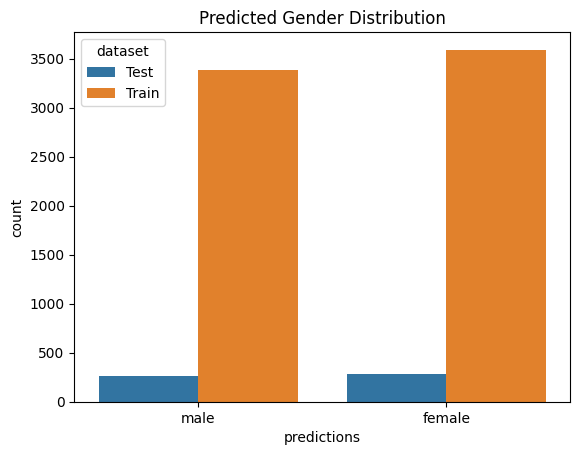

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

df_result_test['dataset'] = 'Test'
df_result_train['dataset'] = 'Train'
combined = pd.concat([df_result_test, df_result_train])

sns.countplot(x='predictions', hue='dataset', data=combined)
plt.title('Predicted Gender Distribution')
plt.show()
